# Agust 2018 Iberian Heatwave case study

This notebook shows how to analyse the output data of the AI-based forecasts of FourCastNetv2.

It is divided into two parts. In the first part we analyse the biases on T2m and Z500 variables during the days the heatwave lasted. In the second part we show how to analyse the Anthropogenic Climate Change (ACC) Attribution using the the Pseudo-Global Warming approach (Brogli et al., 2023).

In [2]:
import xarray as xr
import numpy as np
import datetime
import pandas as pd

# Add the parent directory to the Python path
import sys
sys.path.append('../shared')
import utils
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
#START and END of the runs we use for the evaluation of the heatwave
t0_i = datetime.datetime(2018,7,22,0)
t0_f = datetime.datetime(2018,8,8,18)
delta_h = 6     #delta between runs in hours

#generate the list with all the initialisation dates
init_times = []
current_time = t0_i
while current_time <= t0_f:
    init_times.append(current_time)
    current_time += datetime.timedelta(hours=delta_h)

In [4]:
#load data (modify input directory)
#file structure is organized as follows: '/{root}/{yyyymmddhh}/{var}_{model}_{extension}{yyyymmddhh}.nc'

root='/home/bernatj/Data/ai-forecasts/fcst/'
t2m_ai = utils.load_data('t2m', init_times, root, extension='', model='fcnv2')

In [5]:
#add country mask
t2m_ai_max_iberia = utils.add_land_mask(utils.flip_lon_360_2_180(t2m_ai[:,2::4], t2m_ai.lon).sel(lat=slice(50,30), lon=slice(-12,9))) -273.15
t2m_ai_max_iberia_masked = t2m_ai_max_iberia.where(t2m_ai_max_iberia["land_mask"]==1, drop=True)

In [6]:
#area average over iberia (weighted by cos of latitude)
t2m_ai_max_iberia_avg = utils.area_average(t2m_ai_max_iberia_masked.sel(lat=slice(44,36),lon=slice(-10,3)))

In [7]:
#from init time to lead time
time_range = t2m_ai.time.sel(time=slice('2018-07-28','2018-08-08')) #range of forecasted times
init_time_min = datetime.datetime(2018, 7, 22, 0) #first simulation to consider
lead_time_range = np.arange(0,10*24,6)  #lead times

#convert init time to lead time and only select 12 UTC times
t2m_ai_max_iberia_avg_leadtime = utils.from_init_time_to_leadtime(t2m_ai_max_iberia_avg, init_time_min, lead_time_range, time_range)[:,2::4]

In [8]:
#bias as a function of lead time (remember lead time 0 corresponds to initialisation and that is ERA5)
bias_leadtime = t2m_ai_max_iberia_avg_leadtime - t2m_ai_max_iberia_avg_leadtime[0]

Text(0.5, 1.0, 'BIAS Iberian mean 2m-Temperature at 12UTC [36-44$^{\\circ}$N, 10$^{\\circ}$W-3$^{\\circ}$E]')

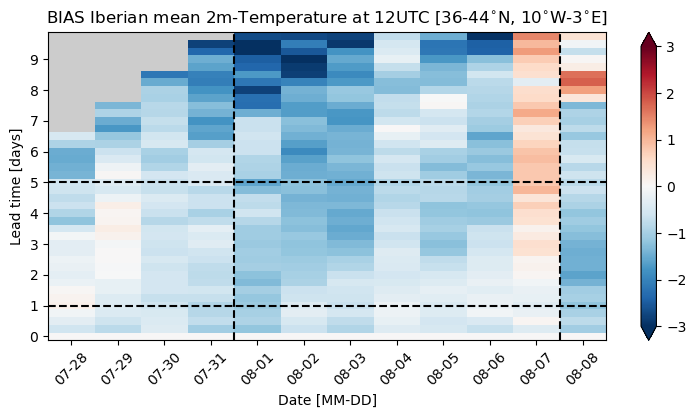

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a new figure with desired size
fig, ax = plt.subplots(figsize=(9, 4))
ax.set_facecolor('0.8')
# Plot t2m_era5_max_iberia_avg
bias_leadtime[0:41,0:12].plot(ax=ax, cmap='RdBu_r', vmax=3, vmin=-3, extend='both')

# Add vertical lines at August 1 and August 7
# Convert date strings to datetime objects
aug_1 = pd.to_datetime('2018-08-01')
aug_7 = pd.to_datetime('2018-08-08')

# Add a filled background between the vertical lines
ax.axvline(x=aug_1, color='k', linestyle='--')
ax.axvline(x=aug_7, color='k', linestyle='--')

ax.axhline(y=1*24, color='k', linestyle='--')
ax.axhline(y=5*24, color='k', linestyle='--')


# Set the x-axis tick positions to the middle of the raster boxes
ax.set_yticks(bias_leadtime[0:41:4,0:12].lead_time)
# Set the tick labels to the desired dates
labels = [(value.values/24) for value in bias_leadtime[0:41:4,0:12].lead_time]
ax.set_yticklabels(int(label) for label in labels)

# Set the x-axis tick positions to the middle of the raster boxes
ax.set_xticks(bias_leadtime[:,0:12].time)
# Set the tick labels to the desired dates
ax.set_xticklabels(bias_leadtime[:,0:12].time.dt.strftime('%m-%d').values)

# Rotate the tick labels for better readability
plt.xticks(rotation=45)

# Add labels and title
ax.set_xlabel('Date [MM-DD]')
ax.set_ylabel('Lead time [days]')
ax.set_title('BIAS Iberian mean 2m-Temperature at 12UTC [36-44$^{\circ}$N, 10$^{\circ}$W-3$^{\circ}$E]')

#plt.savefig('BIAS_leadtime_vs_time_2018HW_Iberia_FourCastNet_wrt_ERA5.pdf',bbox_inches='tight')

## LAGGED ENSEMBLE MEAN STATISTICS

In [10]:
#same but using leadtime to produce the spread
lead_time_slice=slice(1*24,5*24)
ens_mean = t2m_ai_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice).mean('lead_time')  
ens_max = t2m_ai_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice).max('lead_time') 
ens_min = t2m_ai_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice).min('lead_time') 
ens_p90 = t2m_ai_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice).quantile(0.75,'lead_time') 
ens_p10 = t2m_ai_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice).quantile(0.25,'lead_time') 

Text(0.5, 1.0, 'Iberian mean 2m-Temperature at 12UTC [36-44$^{\\circ}$N, 10$^{\\circ}$W-3$^{\\circ}$E]')

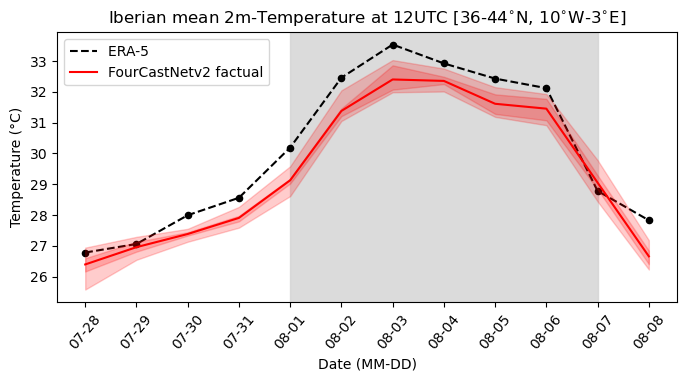

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a new figure with desired size
fig, ax = plt.subplots(figsize=(8, 3.5))

# Plot t2m_era5_max_iberia_avg
time=t2m_ai_max_iberia_avg_leadtime[0,0:15].time
line = ax.plot(time,t2m_ai_max_iberia_avg_leadtime[0,0:15], label='ERA-5 ', color='k', linestyle='--')
sc = ax.scatter(time,t2m_ai_max_iberia_avg_leadtime[0,0:15], color='k', s=20, zorder=2)

# Plot t2m_ai_max_iberia_avg
ens_mean[0:15].plot(ax=ax, label='FourCastNetv2 factual', color='red', linestyle='-', zorder=102)
ax.fill_between(ens_min['time'][0:15], ens_min[0:15], ens_max[0:15], color='red', alpha=0.2, zorder=101)
ax.fill_between(ens_min['time'][0:15], ens_p10[0:15], ens_p90[0:15], color='red', alpha=0.2, zorder=100)

# Add vertical lines at August 1 and August 7
# Convert date strings to datetime objects
aug_1 = pd.to_datetime('2018-08-01-12')
aug_7 = pd.to_datetime('2018-08-07-12')

# Add a filled background between the vertical lines
ax.axvspan(aug_1, aug_7, color='lightgray', alpha=0.8)

# Set the x-axis tick positions to the middle of the raster boxes
ax.set_xticks(t2m_ai_max_iberia_avg_leadtime.time[:])
ax.set_xticklabels(t2m_ai_max_iberia_avg_leadtime.time[:].dt.strftime('%m-%d').values,fontsize=10)
# Rotate the tick labels for better readability
plt.xticks(rotation=50)

# Add legend
ax.legend(fontsize=10)

# Add labels and title
ax.set_xlabel('Date (MM-DD)')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Iberian mean 2m-Temperature at 12UTC [36-44$^{\circ}$N, 10$^{\circ}$W-3$^{\circ}$E]')

#plt.savefig('time_evolution_time_2018HW_Iberia_FourCastNet_wrt_ERA5_leadtime_1d-5d.pdf',bbox_inches='tight')

# Geographyical evolution of the bias

In [12]:
#calculate lead time t2m over iberia 
t2m_iberia_leadtime = utils.from_init_time_to_leadtime(t2m_ai_max_iberia_masked,init_time_min, lead_time_range, time_range)[:,2::4]
#calculate bias
t2m_iberia_leadtime_bias = t2m_iberia_leadtime - t2m_iberia_leadtime[0]

#calculate lead time dependent ensemble mean and standard deviation
lead_time_slice=slice(1*24,5*24)
ens_mean = t2m_iberia_leadtime.sel(lead_time=lead_time_slice).mean('lead_time')  
ens_std = t2m_iberia_leadtime.sel(lead_time=lead_time_slice).std('lead_time')
t2m_ai_bias_ens_iberia = (ens_mean - t2m_iberia_leadtime[0]).load()

/home/bernatj/miniconda3/envs/ddp/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


- ERA5 evolution plot
- Plotting of the evolution of the ensemble mean bias
- Plotting of the ensemble spread (days 1 to 5)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr

plt.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = 7, 7

def plot_variable(data, colorbar_label, file_name, save_plot=False, vmin=None, vmax=None, cmap='RdBu_r'):

    lat, lon = data.lat, data.lon
    nLons = np.arange(-180, 181, 5)
    nLats = np.arange(-90, 91, 5)
    lonW, lonE = -10, 3
    latN, latS = 44, 36

    alphabet_list = [chr(i) for i in range(ord('a'), ord('a') + 15)]
    
    # Create subplots with shared y-axis and manually share x-axis
    f, axes = plt.subplots(3, 4, sharey=True, sharex=True, figsize=(10,8.5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None)))
    
    for i, ax in enumerate(axes.flatten()):
        try:
            ax.set_title(f'({alphabet_list[i]}) ' + data.time.dt.strftime('%Y-%m-%d %HUTC').values[i], fontsize=11)
            ax.set_xticks(nLons, crs=ccrs.PlateCarree())
            ax.set_yticks(nLats, crs=ccrs.PlateCarree())
            ax.tick_params(axis='both', which='major', labelsize=8)
            ax.set_ylim([35, 48])
            ax.set_xlim([-11, 6])
            ax.set_facecolor('0.9')
            ax.coastlines(lw=0.8, color='k')  
            ax.gridlines(linestyle='--', zorder=3, alpha=0.7, xlocs=nLons, ylocs=nLats)
            ax.xaxis.set_major_formatter(LongitudeFormatter())
            ax.yaxis.set_major_formatter(LatitudeFormatter())
            ax.set_aspect(1)
            
            # Define color limits
            h = ax.pcolormesh(lon, lat, data[i], cmap=cmap, vmin=vmin, vmax=vmax)
            
            ax.plot([lonW, lonE], [latS, latS], lw='1.0', ls='--', color='g', transform=ccrs.PlateCarree())
            ax.plot([lonW, lonE], [latN, latN], lw='1.0', ls='--', color='g', transform=ccrs.PlateCarree())
            ax.plot([lonW, lonW], [latS, latN], lw='1.0', ls='--', color='g', transform=ccrs.PlateCarree())
            ax.plot([lonE, lonE], [latS, latN], lw='1.0', ls='--', color='g', transform=ccrs.PlateCarree())
        except IndexError:
            f.delaxes(axes.flatten()[i])
    
    # Adjust size and layout
    f.subplots_adjust(hspace=0.2, wspace=0.2, left=0.0, right=0.95, bottom=0.05, top=0.95)
    
    # Add common colorbar
    cbar = plt.colorbar(h, ax=axes, label=colorbar_label, pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)
    
    # Save figure
    if save_plot:
        plt.savefig(file_name, bbox_inches='tight')

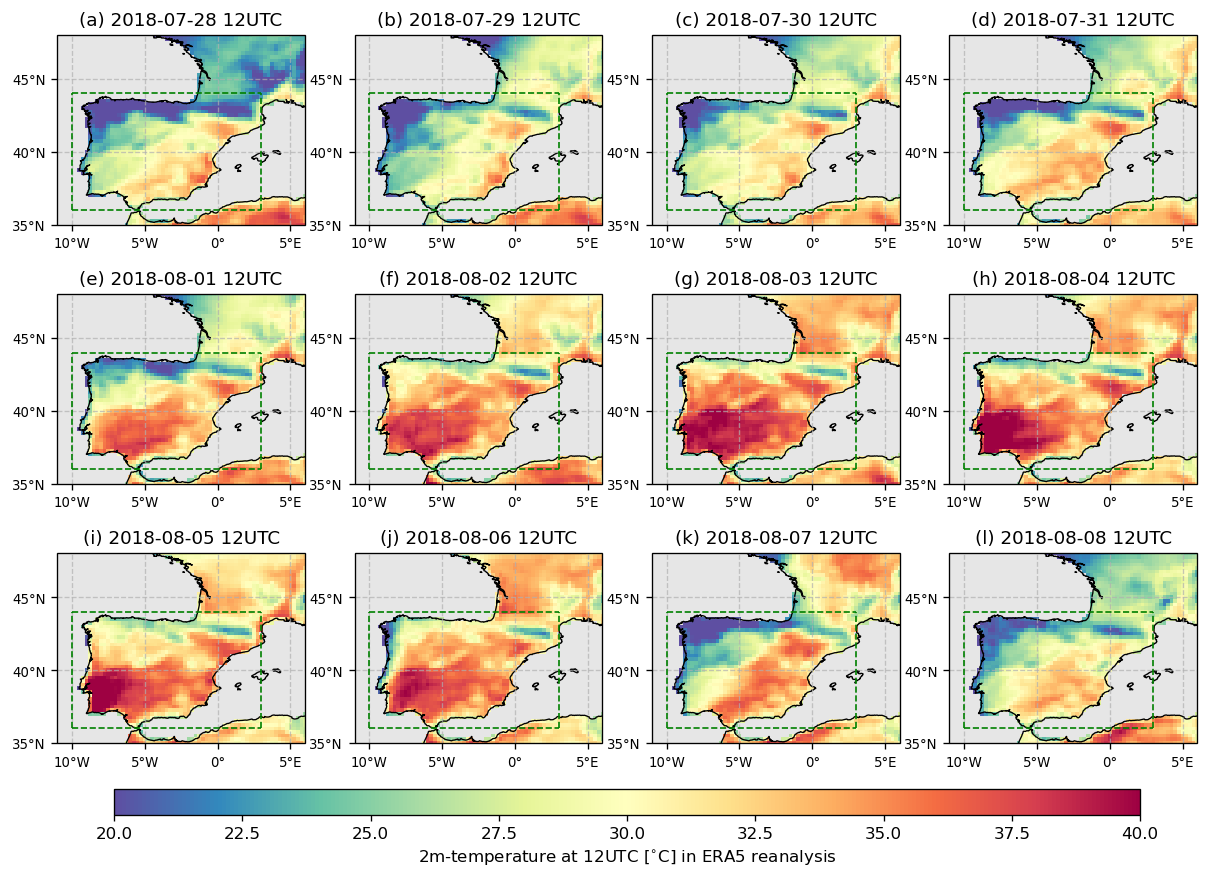

In [18]:
plot_variable(t2m_iberia_leadtime[0], colorbar_label='2m-temperature at 12UTC [$^{\circ}$C] in ERA5 reanalysis',\
               file_name='2018HW_Iberia_ERA5_t2m_evolution_panel.pdf', vmin=20, vmax=40, cmap='Spectral_r')

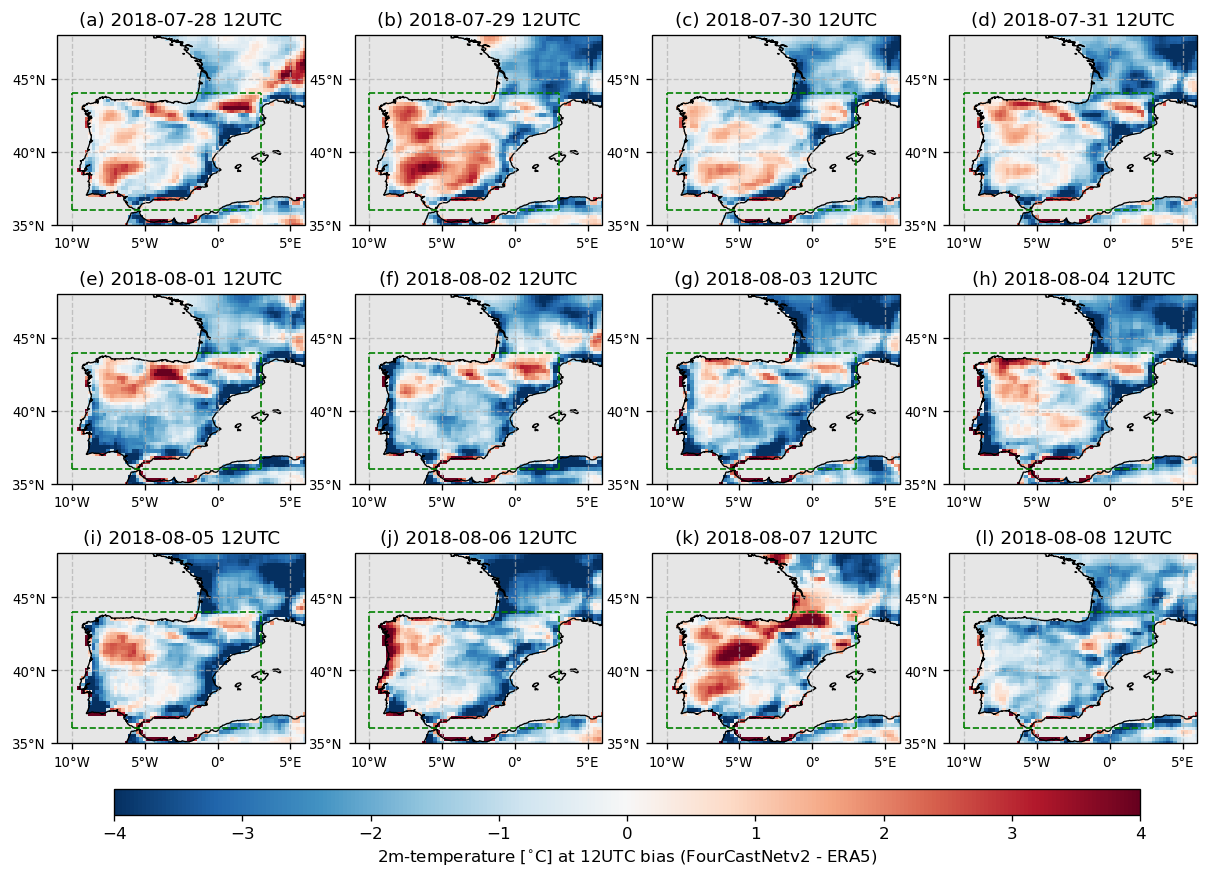

In [19]:
plot_variable(data=t2m_ai_bias_ens_iberia, colorbar_label='2m-temperature [$^{\circ}$C] at 12UTC bias (FourCastNetv2 - ERA5)',\
               file_name='2018HW_Iberia_bias_latlon_leadtime_average_1-5days.pdf', vmin=-4, vmax=4)

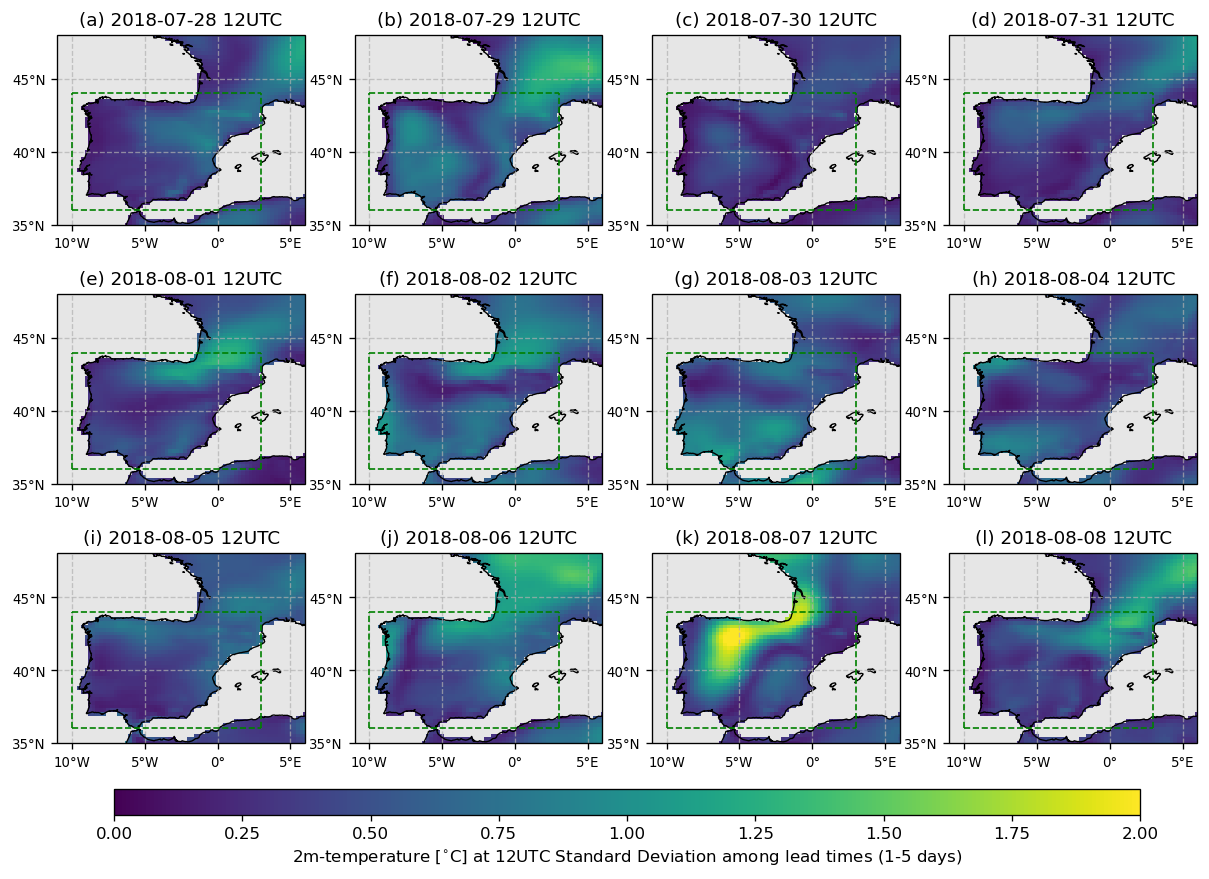

In [20]:
plot_variable(ens_std, colorbar_label='2m-temperature [$^{\circ}$C] at 12UTC Standard Deviation among lead times (1-5 days)',\
               file_name='2018HW_Iberia_ensstddev_latlon_leadtime_avergage_1-5days.pdf', vmin=0, vmax=2, cmap='viridis')

# SUMMARY PLOT (AVERAGE DURING THE HEATWAVE PERIOD)

/tmp/ipykernel_3420652/1291280942.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap('RdBu_r', 256)


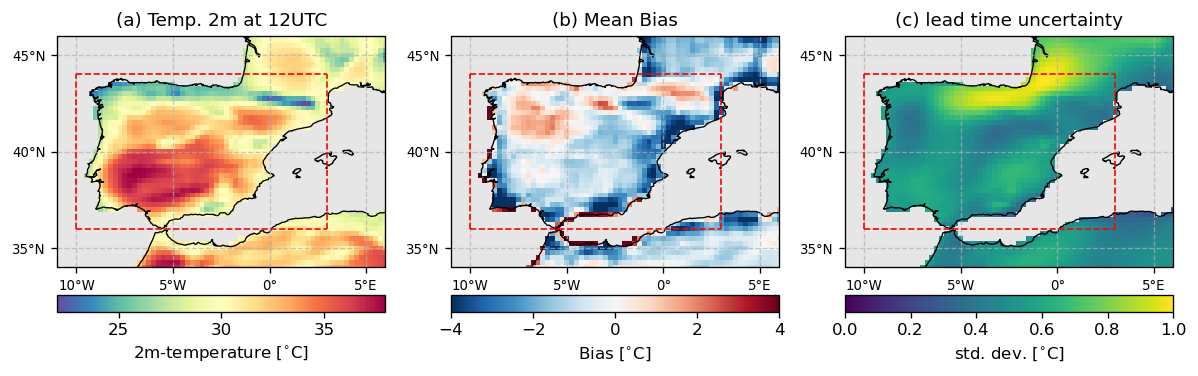

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

plt.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = 7, 7

#average for the event
data = ens_mean.sel(time=slice('2018-08-01','2018-08-07')).mean('time')
data2 = t2m_ai_bias_ens_iberia.sel(time=slice('2018-08-01','2018-08-07')).mean('time')
data3 = ens_std.sel(time=slice('2018-08-01','2018-08-07')).mean('time')

# Create subplots with shared y-axis and manually share x-axis
f, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(12,6), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None)))

#lev = np.arange(-3,3.1,0.25)
lev = np.arange(16,42.1,1)
lev2 = np.arange(5300,6000,80)
colors = mpl.cm.get_cmap('RdBu_r', 256)
newcolors = colors(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[120:137, :] = white
newcmap = mpl.colors.ListedColormap(newcolors)

lat, lon = data.lat, data.lon
nLons = np.arange(-180, 181, 5)
nLats = np.arange(-90, 91, 5)
lonW, lonE = -10, 3
latN, latS = 44, 36

for ax in axes:

    ax.set_xticks(nLons, crs=ccrs.PlateCarree())
    ax.set_yticks(nLats, crs=ccrs.PlateCarree())
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_ylim([34, 46])
    ax.set_xlim([-11, 6])
    ax.set_facecolor('0.9')
    ax.coastlines(lw=0.8, color='k')  
    ax.gridlines(linestyle='--', zorder=3, alpha=0.7, xlocs=nLons, ylocs=nLats)

    # format the ticks as e.g 60°W
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    ax.set_aspect(1)


#pannel 1 (total temperature)
axes[0].set_title('(a) Temp. 2m at 12UTC', fontsize=11)
plot1 = axes[0].pcolormesh(lon, lat, data, cmap='Spectral_r', vmax=38, vmin=22)
cbar1 = plt.colorbar(plot1, ax=axes[0], label='2m-temperature [$^{\circ}$C]', pad=0.05, orientation='horizontal', shrink=1, aspect=20)


#panel 2 (bias)
axes[1].set_title('(b) Mean Bias', fontsize=11)
data= t2m_ai_bias_ens_iberia
plot2 = axes[1].pcolormesh(lon, lat, data2, cmap='RdBu_r', vmax=4, vmin=-4)
cbar2 = plt.colorbar(plot2, ax=axes[1], label='Bias [$^{\circ}$C]', pad=0.05, orientation='horizontal', shrink=1, aspect=20)


#panel 3 (standard deviation)
axes[2].set_title('(c) lead time uncertainty', fontsize=11)
plot3 = axes[2].pcolormesh(lon, lat, data3, cmap='viridis', vmax=1.0, vmin=0)
cbar3 = plt.colorbar(plot3, ax=axes[2], label='std. dev. [$^{\circ}$C]', pad=0.05, orientation='horizontal', shrink=1, aspect=20)

for ax in axes:
    ax.plot([lonW,lonE],[latS,latS], lw='1.0', ls='--', color='r',transform=ccrs.PlateCarree())
    ax.plot([lonW,lonE],[latN,latN],  lw='1.0', ls='--', color='r',transform=ccrs.PlateCarree())
    ax.plot([lonW,lonW],[latS,latN], lw='1.0', ls='--', color='r',transform=ccrs.PlateCarree())
    ax.plot([lonE,lonE],[latS,latN], lw='1.0', ls='--', color='r',transform=ccrs.PlateCarree())

#save figure
#plt.savefig('2018HW_Iberia_panel_event_Average_1-7Aug_lt_1-5d_bias.pdf',bbox_inches='tight')


## Geopotential at 500 hPa bias

In [22]:
z500_ai = utils.load_data('z500', init_times, root, extension='', model='fcnv2')

In [ ]:
z500_europe = utils.flip_lon_360_2_180(z500_ai[:,2::4],z500_ai.lon).sel(lat=slice(70,20),lon=slice(-40,50))

In [ ]:
#from init time to lead time
time_range = z500_ai.time.sel(time=slice('2018-07-28','2018-08-08'))
init_time_min = datetime.datetime(2018, 7, 22, 0)
lead_time_range = np.arange(0,10*24,6)
z500_leadtime = utils.from_init_time_to_leadtime(z500_europe,init_time_min, lead_time_range, time_range)[:,2::4]


In [ ]:
z500_ens_mean = z500_leadtime.sel(lead_time=slice(1*24,5*24)).mean('lead_time')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr

plt.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = 7, 7

def plot_z500(data, colorbar_label, file_name, show_plot=True, vmin=5400, vmax=6000, cmap='Spectral_r'):
    lat, lon = data.lat, data.lon
    nLons = np.arange(-180, 181, 20)
    nLats = np.arange(-90, 91, 10)

    # Create subplots with shared y-axis and manually share x-axis
    f, axes = plt.subplots(3, 4, sharey=True, sharex=True, figsize=(10,8.5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None)))

    for i, ax in enumerate(axes.flatten()):
        try:
            ax.set_title(data.time.dt.strftime('%Y-%m-%d %HUTC').values[i], fontsize=11)

            if i % 4 == 0:
                ax.set_yticks(nLats, crs=ccrs.PlateCarree())
            if i >= 4 * 2:
                ax.set_xticks(nLons, crs=ccrs.PlateCarree())

            ax.tick_params(axis='both', which='major', labelsize=8)
            ax.set_facecolor('0.9')
            ax.coastlines(lw=0.8, color='k')
            ax.gridlines(linestyle='--', zorder=3, alpha=0.7, xlocs=nLons, ylocs=nLats)

            # Format the ticks
            ax.xaxis.set_major_formatter(LongitudeFormatter())
            ax.yaxis.set_major_formatter(LatitudeFormatter())

            ax.set_aspect(1.5)

            # Plot the data
            ax.contour(lon, lat, data.isel(time=i), levels=[5400, 5900], colors='k')
            h = ax.pcolormesh(lon, lat, data.isel(time=i), cmap=cmap, vmax=vmax, vmin=vmin)

        except IndexError:
            f.delaxes(axes.flatten()[i])

    # Adjust size and layout
    f.subplots_adjust(hspace=0.2, wspace=0.2, left=0.0, right=0.95, bottom=0.05, top=0.95)

    # Add common colorbar
    cbar = plt.colorbar(h, ax=axes, label=colorbar_label, pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)

    # Save figure
    if save_plot:
        plt.savefig(file_name, bbox_inches='tight')

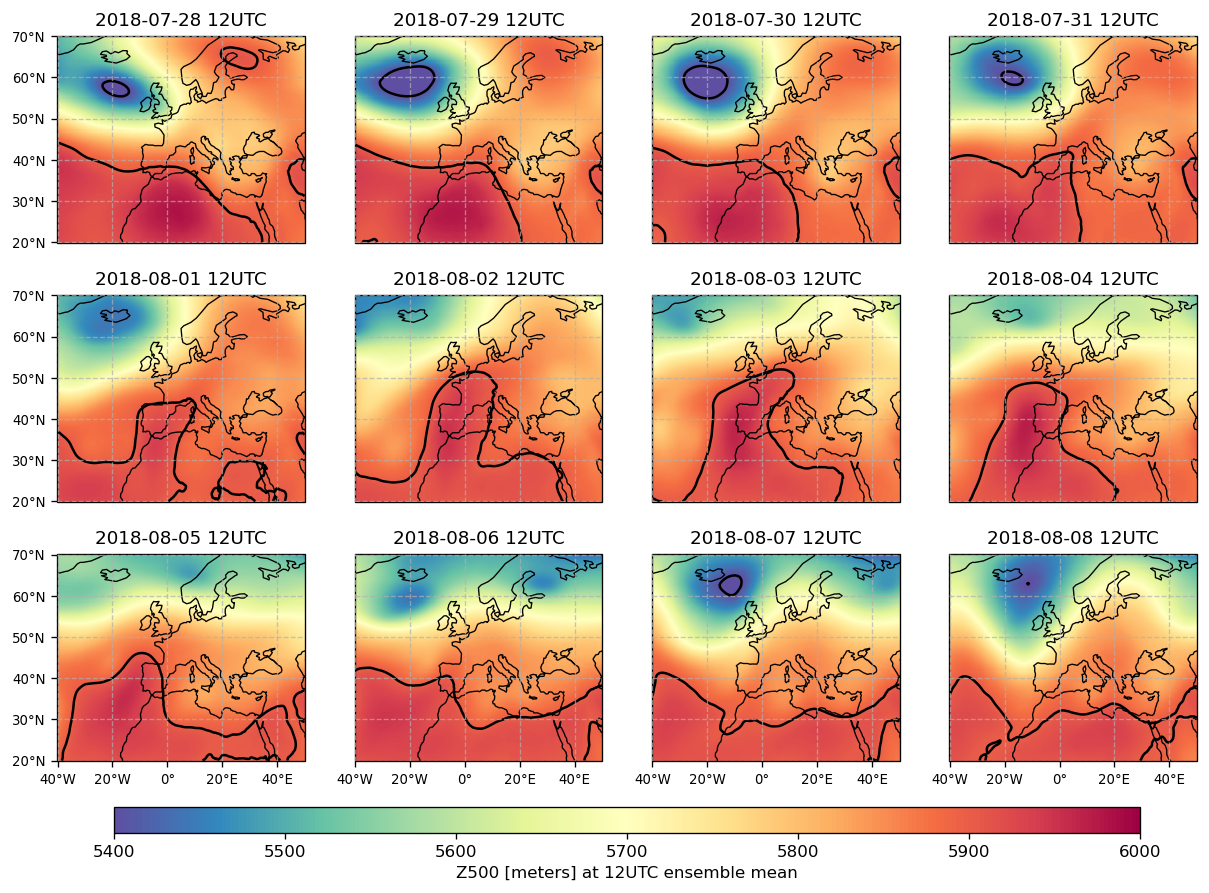

In [ ]:
plot_z500(data=z500_ens_mean/9.806, colorbar_label='Z500 [meters] at 12UTC ensemble mean', file_name='Z500_ensemble_mean.pdf')

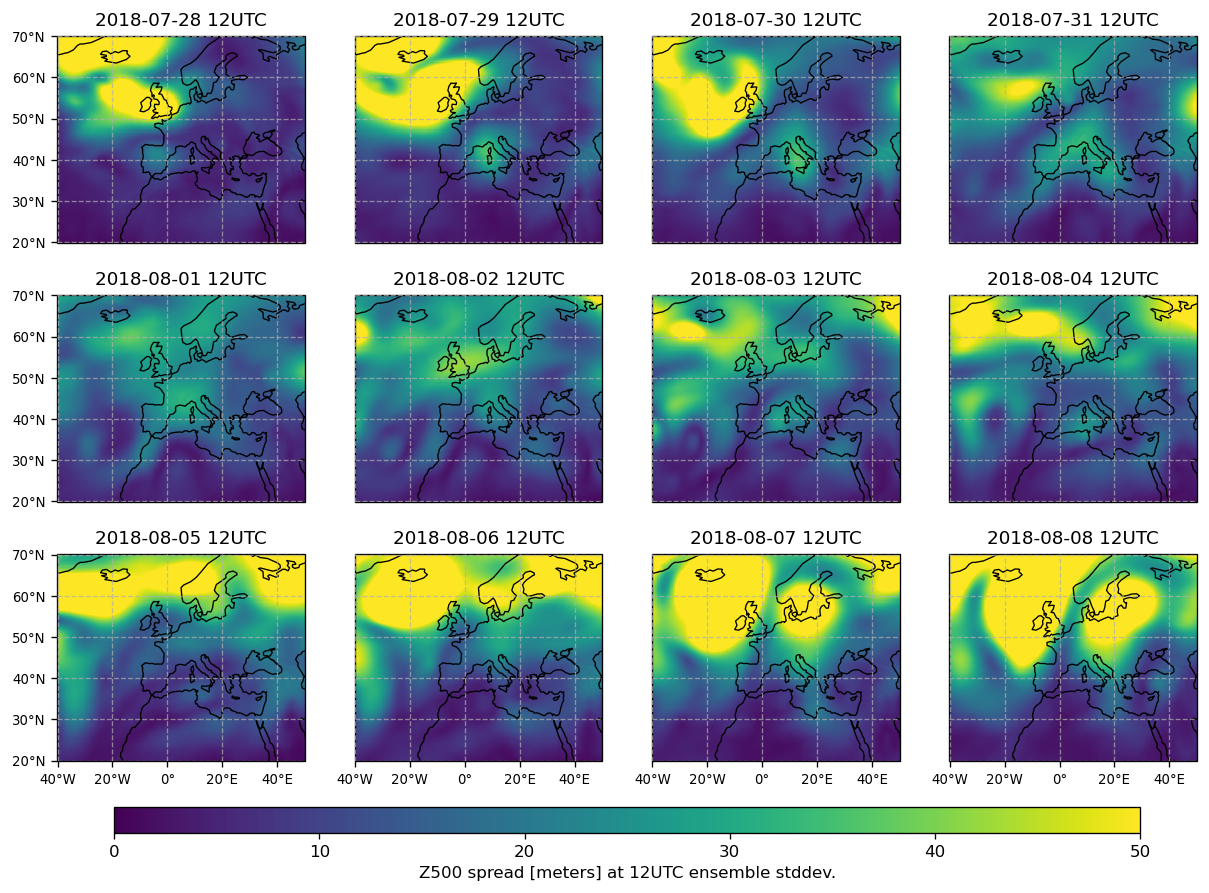

In [ ]:
z500_ens_std =  z500_leadtime.std('lead_time').load()

plot_z500(data=z500_ens_std/9.806, colorbar_label='Z500 spread [meters] at 12UTC ensemble stddev.',\
           file_name='Z500_ensemble_stddev.pdf', vmin=0, vmax=50, cmap='viridis')

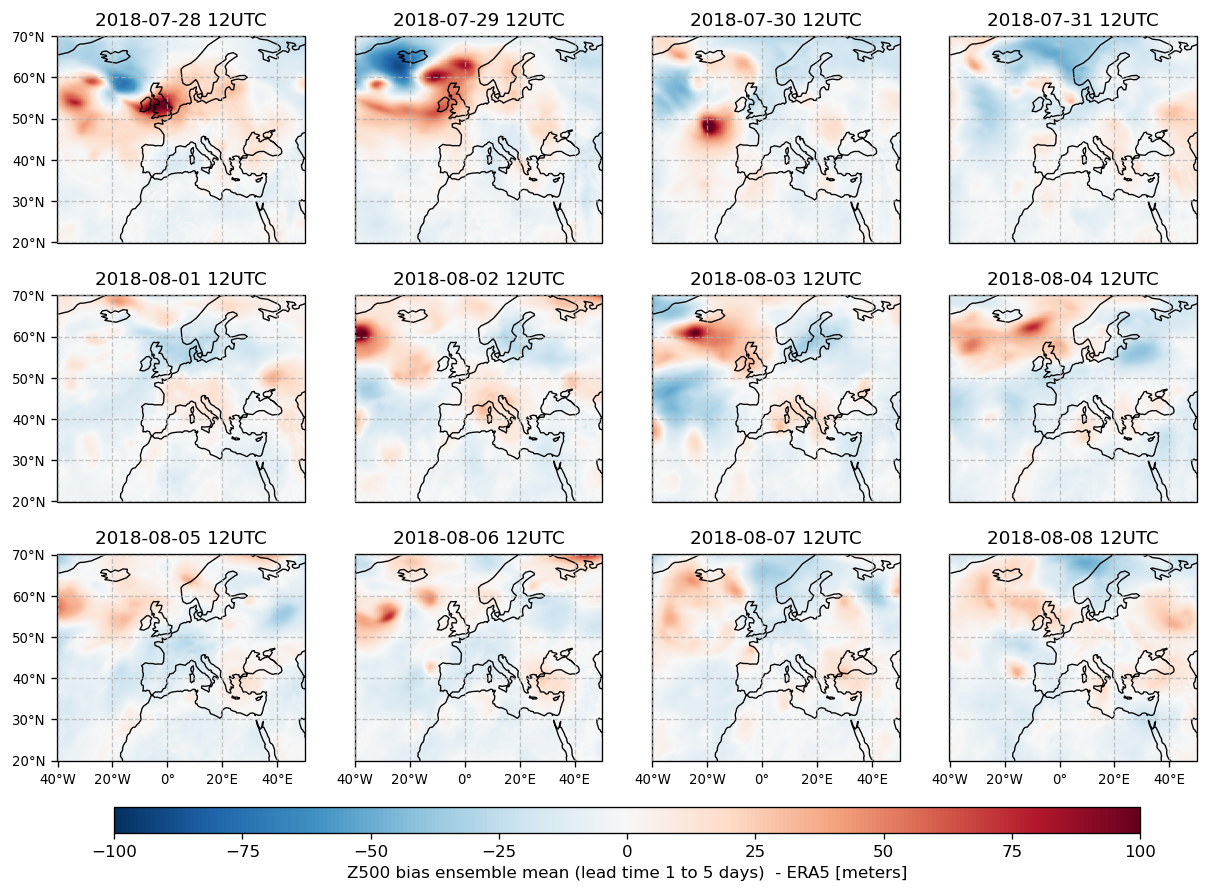

In [ ]:
bias_z500 = z500_ens_mean - z500_leadtime[0]
plot_z500(data=bias_z500/9.806, colorbar_label='Z500 bias ensemble mean (lead time 1 to 5 days)  - ERA5 [meters]',\
           file_name='2018HW_Iberia_pannel_bias_z500_lt_1-5days_ERA5.pdf', vmin=-100, vmax=100, cmap='RdBu_r')


# AI-based Attribution analysis.

- We need to read temperature from the counterfactual simulations t2m_pgw: PGW from pseudo global warming.

In [ ]:
t2m_pgw = utils.load_data('t2m', init_times, root, extension='PGW_multimodel_', model='fcnv2')

In [ ]:
t2m_pgw_max_iberia = utils.add_land_mask(utils.flip_lon_360_2_180(t2m_pgw[:,2::4], t2m_pgw.lon).sel(lat=slice(50,30), lon=slice(-12,9))) -273.15
t2m_pgw_max_iberia_masked = t2m_pgw_max_iberia.where(t2m_pgw_max_iberia["land_mask"]==1, drop=True)

In [ ]:
#average over iberia:
t2m_ai_max_iberia_avg = utils.area_average(t2m_ai_max_iberia_masked.sel(lat=slice(44,36),lon=slice(-10,3)))
t2m_pgw_max_iberia_avg = utils.area_average(t2m_pgw_max_iberia_masked.sel(lat=slice(44,36),lon=slice(-10,3)))

In [ ]:
#from init time to lead time
time_range = t2m_pgw.time.sel(time=slice('2018-07-28','2018-08-08'))
init_time_min = datetime.datetime(2018, 7, 22, 0)
lead_time_range = np.arange(0,10*24,6)

t2m_pgw_max_iberia_avg_leadtime = utils.from_init_time_to_leadtime(t2m_pgw_max_iberia_avg, init_time_min, lead_time_range, time_range)[:,2::4]
t2m_pgw_max_iberia_leadtime  = utils.from_init_time_to_leadtime(t2m_pgw_max_iberia_masked, init_time_min, lead_time_range, time_range)[:,2::4]

In [ ]:
diff_pgw_t2m_iberia = t2m_ai_max_iberia_avg_leadtime - t2m_pgw_max_iberia_avg_leadtime

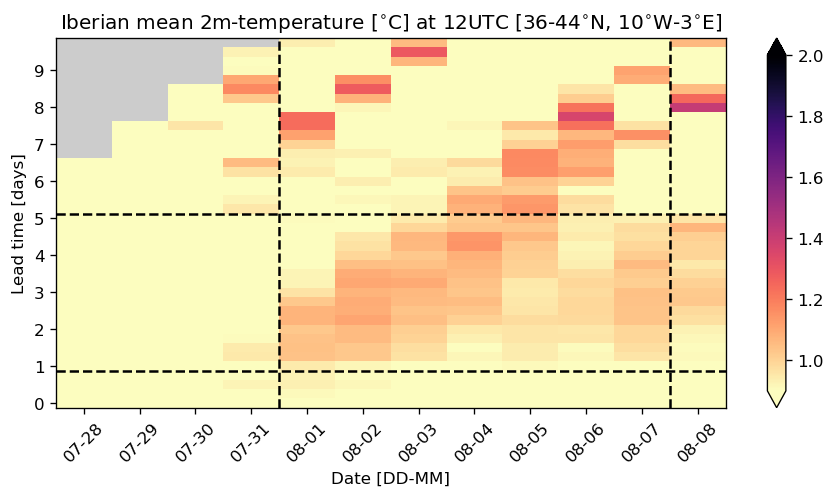

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_diff_pgw_t2m_iberia(diff_pgw_t2m_iberia, save_path):
    
    # Create a new figure with desired size
    fig, ax = plt.subplots(figsize=(9, 4))
    ax.set_facecolor('0.8')
    
    # Plot t2m_era5_max_iberia_avg
    plot1 = diff_pgw_t2m_iberia[0:41,0:12].plot(ax=ax, cmap='magma_r', vmax=1, vmin=2, extend='both')
    
    # Add vertical lines at August 1 and August 7
    aug_1 = pd.to_datetime('2018-08-01')
    aug_7 = pd.to_datetime('2018-08-08')
    
    ax.axvline(x=aug_1, color='k', linestyle='--')
    ax.axvline(x=aug_7, color='k', linestyle='--')
    ax.axhline(y=1*24-3, color='k', linestyle='--')
    ax.axhline(y=5*24+3, color='k', linestyle='--')
    
    ax.set_yticks(diff_pgw_t2m_iberia[0:41:4,0:12].lead_time)
    labels = [(value.values/24) for value in diff_pgw_t2m_iberia[0:41:4,0:12].lead_time]
    ax.set_yticklabels(int(label) for label in labels)
    ax.set_xticks(diff_pgw_t2m_iberia[:,0:12].time)
    ax.set_xticklabels(diff_pgw_t2m_iberia[:,0:12].time.dt.strftime('%m-%d').values)
    plt.xticks(rotation=45)
    
    ax.set_xlabel('Date [DD-MM]')
    ax.set_ylabel('Lead time [days]')
    ax.set_title('Iberian mean 2m-temperature [$^{\\circ}$C] at 12UTC [36-44$^{\\circ}$N, 10$^{\\circ}$W-3$^{\\circ}$E]')
    
    plt.savefig(save_path, bbox_inches='tight')

# Call the function with the appropriate arguments
plot_diff_pgw_t2m_iberia(diff_pgw_t2m_iberia, 'Attribution_leadtime_vs_time_2018HW_Iberia_FourCastNet_mmm_pgw.pdf')


In [ ]:
t2m_iberia_leadtime = utils.from_init_time_to_leadtime(t2m_ai_max_iberia,init_time_min, lead_time_range, time_range)[:,2::4]
t2m_pgw_iberia_leadtime = utils.from_init_time_to_leadtime(t2m_pgw_max_iberia,init_time_min, lead_time_range, time_range)[:,2::4]

In [ ]:
#calculate bias:
lead_time_slice=slice(1*24,5*24)
ens_mean_iberia = t2m_pgw_iberia_leadtime.sel(lead_time=lead_time_slice).mean('lead_time')
ens_mean_iberia_fac = t2m_iberia_leadtime.sel(lead_time=lead_time_slice).mean('lead_time')  

t2m_ai_pgw_iberia = (ens_mean_iberia_fac - ens_mean_iberia).load()

In [ ]:
#significance (2 tailed T-test)
from scipy import stats
sample1= t2m_pgw_iberia_leadtime.sel(lead_time=lead_time_slice).values
sample2= t2m_iberia_leadtime.sel(lead_time=lead_time_slice).values

_, p_value = stats.ttest_ind(sample1, sample2, axis=0)

/tmp/ipykernel_3337462/2322717430.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap('RdBu_r', 256)


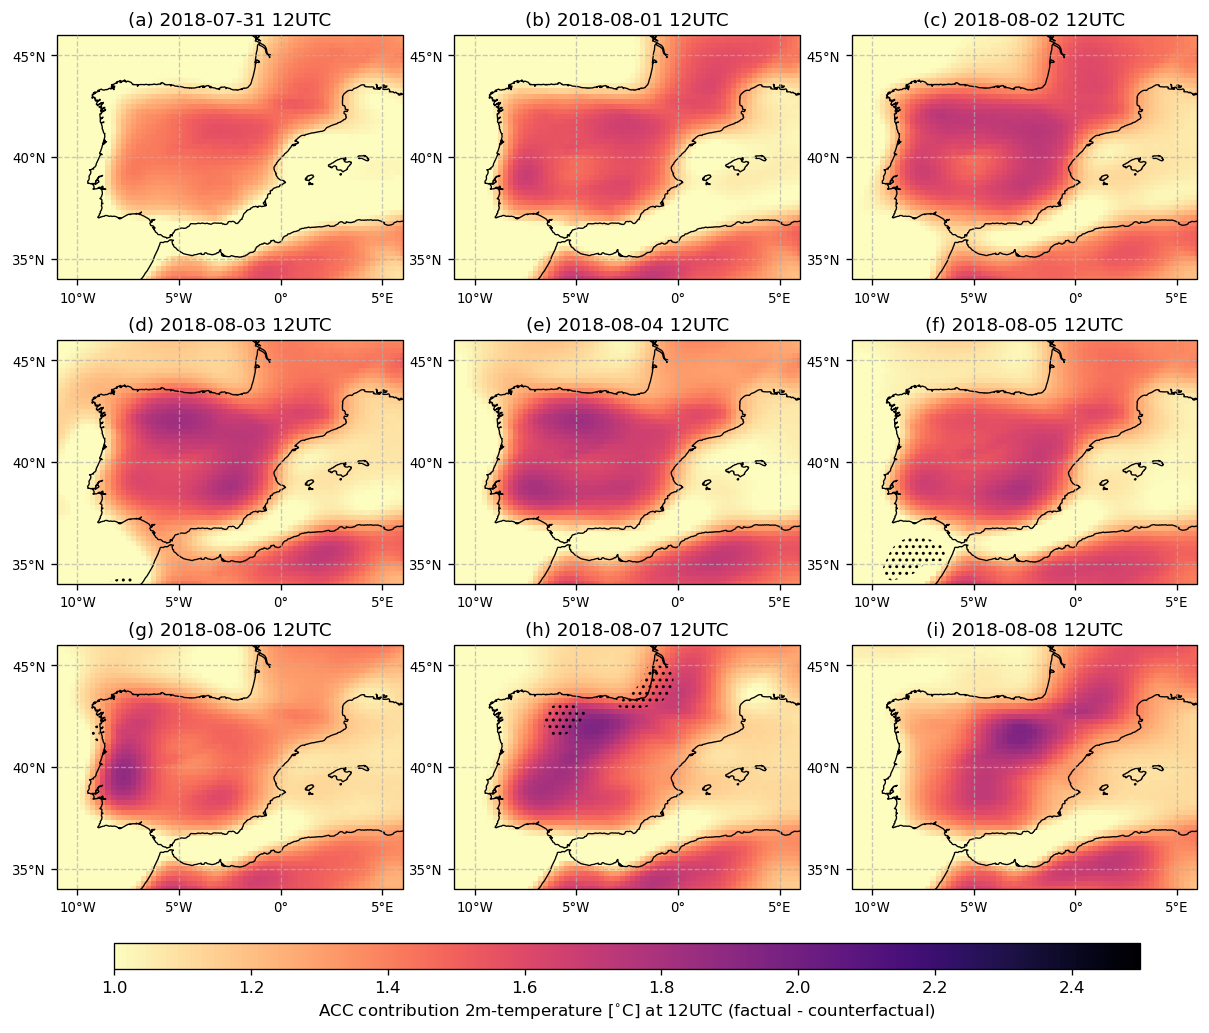

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def plot_data_maps(data, p_val, save_path, cmap='magma_r', vmax=2.5, vmin=1):
    """
    This function plots the given data on a map using cartopy and matplotlib.
    
    Parameters:
    data: The data to be plotted.
    p_val: The p_values associated with the data.
    alphabet_list: A list of alphabets for labeling the subplots.
    save_path: The path where the plot will be saved.
    """
    plt.rcParams['figure.dpi'] = 120
    mpl.rcParams['figure.figsize'] = 7, 7

    # Create subplots with shared y-axis and manually share x-axis
    f, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(10,10), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None)))

    lev = np.arange(16,42.1,1)
    lev2 = np.arange(5300,6000,80)
    colors = mpl.cm.get_cmap('RdBu_r', 256)
    newcolors = colors(np.linspace(0, 1, 256))
    white = np.array([1, 1, 1, 1])
    newcolors[120:137, :] = white
    newcmap = mpl.colors.ListedColormap(newcolors)

    lat, lon = data.lat, data.lon
    nLons = np.arange(-180, 181, 5)
    nLats = np.arange(-90, 91, 5)

    alphabet_list = [chr(i) for i in range(ord('a'), ord('a') + 15)]

    # Loop through subplots
    for i, ax in enumerate(axes.flatten()):
        ax.set_title(f'({alphabet_list[i]}) '+data.time.dt.strftime('%Y-%m-%d %HUTC').values[i], fontsize=11)

        ax.set_xticks(nLons, crs=ccrs.PlateCarree())
        ax.set_yticks(nLats, crs=ccrs.PlateCarree())
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_ylim([34, 46])
        ax.set_xlim([-11, 6])
        
        ax.set_facecolor('0.9')
        ax.coastlines(lw=0.8, color='k')  
        ax.gridlines(linestyle='--', zorder=3, alpha=0.7, xlocs=nLons, ylocs=nLats)

        # format the ticks as e.g 60°W
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        ax.yaxis.set_major_formatter(LatitudeFormatter())

        ax.set_aspect(1)

        h = ax.pcolormesh(lon, lat, data[i], cmap=cmap, vmax=vmax, vmin=vmin)
        p = ax.contourf(lon, lat, p_val[i], colors='none', levels=[0.01,1], hatches=['...',''])

    # Adjust size
    f.subplots_adjust(hspace=0.2, wspace=0.15, left=0.0, right=0.95, bottom=0.05, top=0.95)

    # Add common colorbar
    cbar = plt.colorbar(h, ax=axes, label='ACC contribution 2m-temperature [$^{\\circ}$C] at 12UTC (factual - counterfactual)', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)

    # Save figure
    plt.savefig(save_path, bbox_inches='tight')

# Call the function with the appropriate arguments
plot_data_maps(t2m_ai_pgw_iberia[3:18], p_value[3:18], '2018HW_Iberia_pannel_diff_FourCastNet_factual-counterfactual-leadtime_1-5d.pdf')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

plt.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = 7, 7

data= t2m_ai_pgw_iberia[2:18] 
p_val = p_value[2:18]
# Create subplots with shared y-axis and manually share x-axis
f, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(9,5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None)))

#lev = np.arange(-3,3.1,0.25)
lev = np.arange(16,42.1,1)
lev2 = np.arange(5300,6000,80)
colors = mpl.cm.get_cmap('RdBu_r', 256)
newcolors = colors(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[120:137, :] = white
newcmap = mpl.colors.ListedColormap(newcolors)

lat, lon = data.lat, data.lon
nLons = np.arange(-180, 181, 5)
nLats = np.arange(-90, 91, 5)

# Loop through subplots
for i, ax in enumerate(axes.flatten()):
    if i==0:
        ax.set_yticks(nLats, crs=ccrs.PlateCarree()) 
    ax.set_xticks(nLons, crs=ccrs.PlateCarree())
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_ylim([34, 46])
    ax.set_xlim([-11, 6])
    
    ax.set_facecolor('0.9')
    ax.coastlines(lw=0.8, color='k')  
    ax.gridlines(linestyle='--', zorder=3, alpha=0.7, xlocs=nLons, ylocs=nLats)

    # format the ticks as e.g 60°W
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    ax.set_aspect(1)

#axes[0].set_title( data.time.dt.strftime('%Y-%m-%d %HUTC').values[i], fontsize=11)

period1=slice('2018-07-29','2018-07-31')
period2=slice('2018-08-02','2018-08-04')
period3=slice('2018-08-06','2018-08-08')

# Explicitly pass the ax parameter to contourf
#h = ax.contourf(lon, lat, data[i], cmap='Spectral_r', levels=lev, extend='both', alpha=1.0) 

axes[0].set_title('29 Jul - 31 Jul', fontsize=11)
data= t2m_ai_pgw_iberia.sel(time=period1).mean('time') 
plot1 = axes[0].pcolormesh(lon, lat, data, cmap='magma_r', vmax=2.5, vmin=1)
sample1=t2m_pgw_iberia_leadtime.sel(lead_time=lead_time_slice).sel(time=period1).mean('time') 
sample2=t2m_iberia_leadtime.sel(lead_time=lead_time_slice).sel(time=period1).mean('time') 
_, p_value = stats.ttest_ind(sample1, sample2, axis=0)
p = ax.contourf(lon, lat, p_value, colors='none', levels=[0.01,1], hatches=['...',''])

axes[1].set_title('2 Aug - 4 Aug', fontsize=11)
data= t2m_ai_pgw_iberia.sel(time=period2).mean('time') 
plot2 = axes[1].pcolormesh(lon, lat, data, cmap='magma_r', vmax=2.5, vmin=1)
sample1=t2m_pgw_iberia_leadtime.sel(lead_time=lead_time_slice).sel(time=period2).mean('time') 
sample2=t2m_iberia_leadtime.sel(lead_time=lead_time_slice).sel(time=period2).mean('time') 
_, p_value = stats.ttest_ind(sample1, sample2, axis=0)
p = ax.contourf(lon, lat, p_value, colors='none', levels=[0.01,1], hatches=['...',''])

axes[2].set_title('6 Aug - 8 Aug', fontsize=11)
data= t2m_ai_pgw_iberia.sel(time=period3).mean('time') 
plot3 = axes[2].pcolormesh(lon, lat, data, cmap='magma_r', vmax=2.5, vmin=1)
sample1=t2m_pgw_iberia_leadtime.sel(lead_time=lead_time_slice).sel(time=period3).mean('time') 
sample2=t2m_iberia_leadtime.sel(lead_time=lead_time_slice).sel(time=period3).mean('time') 
_, p_value = stats.ttest_ind(sample1, sample2, axis=0)
p = ax.contourf(lon, lat, p_value, colors='none', levels=[0.01,1], hatches=['...',''])

#p = ax.contourf(lon, lat, p_val[i], colors='none', levels=[0.01,1], hatches=['////////',''])

# Adjust size
f.subplots_adjust(hspace=0.2, wspace=0.15, left=0.0, right=0.95, bottom=0.05, top=0.95)

# Add common colorbar
cbar = plt.colorbar(h, ax=axes, label='ACC contribution 2m-temperature [$^{\circ}$C] at 12UTC (factual - counterfactual)', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)
#cbar = plt.colorbar(h, ax=axes, label='BIAS in 2M-Temperature at 12UTC FourcastNet (Factual - Counterfactual)', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)

#save figure
plt.savefig('2018HW_Iberia_pannel_diff_FourCastNet_factual-counterfactual-leadtime_1-5d_3periods_2.pdf',bbox_inches='tight')

NameError: name 't2m_ai_pgw_iberia' is not defined

## Violin plots for teh factual and counterfactula worlds

In [ ]:
t2m_ai_max_iberia_avg_leadtime_pdf =  t2m_ai_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice, \
                                                                  time=slice('2018-08-01','2018-08-07')).values.ravel()
t2m_pgw_max_iberia_avg_leadtime_pdf = t2m_pgw_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice, \
                                                                  time=slice('2018-08-01','2018-08-07')).values.ravel()

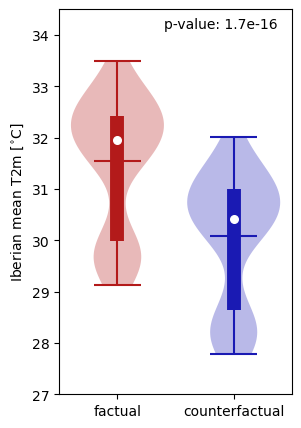

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


data1=t2m_ai_max_iberia_avg_leadtime_pdf
data2=t2m_pgw_max_iberia_avg_leadtime_pdf

#significance
from scipy import stats

_, p_value = stats.ttest_ind(data1, data2, axis=0)

data = [data1, data2]
# Create a new figure
fig, ax = plt.subplots(figsize=(3,5))

# Create violin plots
parts = ax.violinplot([data1, data2], [0.5,1.5],showmeans=True,widths=0.8)

# Change the color of each violin
colors = [(0.7,0.1,0.1), (0.1,0.1,0.7)]
for i, body in enumerate(parts['bodies']):
    body.set_facecolor(colors[i])

# Change the color of the lines
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = parts[partname]
    vp.set_edgecolor(colors)
    
quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)

ax.scatter([0.5,1.5], medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(0.5, quartile1[0], quartile3[0], color=colors[0], linestyle='-', lw=10)
ax.vlines(1.5, quartile1[1], quartile3[1], color=colors[1], linestyle='-', lw=10)

# Add title and labels
ax.set_title('')
ax.set_ylabel('Iberian mean T2m [$^{\circ}$C]')
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(['factual', 'counterfactual'])

ax.text(0.45,0.95,f'p-value: {p_value:.1e}',transform=ax.transAxes)

ax.set_xlim([0, 2])
ax.set_ylim([27, 34.5])  # replace 0.5 with your desired y-axis upper limit

# Show the plot
plt.savefig('2018HW_Iberia_PDF_difference_1-7August_leadtime_1-5d.pdf',bbox_inches='tight')